In [5]:
import xnet
import json
import glob

import numpy as np
import matplotlib.pyplot as plt

from igraph import *
from collections import defaultdict
from matplotlib.ticker import MaxNLocator
from util import save,load
from util import get_attr_pacs,get_pac_list,get_pacs_paper_published

In [6]:
attr_pacs = get_attr_pacs()
pac_list = get_pac_list()

In [7]:
def get_in(paper,data):
    pacs = []
    p_neighbors = data.neighbors(paper,mode=IN)
    n_neighbors = len(p_neighbors)
    return n_neighbors

def get_out(paper,data):
    pacs = []
    p_neighbors = data.neighbors(paper,mode=OUT)
    n_neighbors = len(p_neighbors)
    return n_neighbors

In [8]:
def get_freq_of(data,get_freq,delta,filename):

	history = defaultdict(lambda:defaultdict(lambda:0))

	year_begin = 1990
	year_end = 2010

	for i,year in enumerate(range(year_begin,year_end+1)):
		print("current year %d" % year)
		subset = data.vs.select(year_ge=year,year_le=year+delta)
		subgraph = data.subgraph(subset)
		for paper in subgraph.vs:
			authors_idxs = paper['authors_idxs'].split(',')
			value = get_freq(paper,subgraph)
			for author in authors_idxs:
				history[author][year] += value
		save(history,filename)

	return history

In [9]:
data = xnet.xnet2igraph('data/citation_network_ge1990_pacs.xnet')

filenames = sorted(glob.glob('data/pacs/2lvls/*_multilevel0.xnet'))
pac_nets = []
for filename in filenames:
	net = xnet.xnet2igraph(filename)
	pac_nets.append(net)

In [10]:
# get_freq_of(data,get_in,4,'authors_in_freq.json')

In [11]:
# get_freq_of(data,get_out,'authors_out_freq.json')

# get_freq_of(data,get_in,4,'authors_in_freq.json')

In [15]:
authors_out = load('authors_out_freq.json')
authors_in = load('authors_in_freq.json')

In [12]:
def get_min_freqs(data,min_values):
    freq = defaultdict(lambda:[])
    for author,a_hist in data.items():
        for year,value in a_hist.items():
            freq[year].append(value)
    
    years = []
    freqs_dict = {}
    for min_value in min_values:
        freqs_dict[min_value] = []
    
    for year,freqs in freq.items():
        years.append(year)
        freqs = np.asarray(freqs)
        total = len(freqs)
        
        for min_value in min_values:
            p = 100*sum(freqs >= min_value)/total
            freqs_dict[min_value].append(p)
    return years,freqs_dict

In [13]:
def plot_min_values(years,freqs_dict,title):
    plt.figure(figsize=(10,3))
    for min_value,freqs in freqs_dict.items():
        plt.plot(years,freqs,marker='o',ls='-',label=min_value)
    plt.legend()
    plt.xlabel('year')
    plt.xticks(rotation=45)
    plt.ylabel('%')
    plt.title(title)
    plt.ylim((0, 15))
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('temp/%s.pdf' % title)
    plt.show()

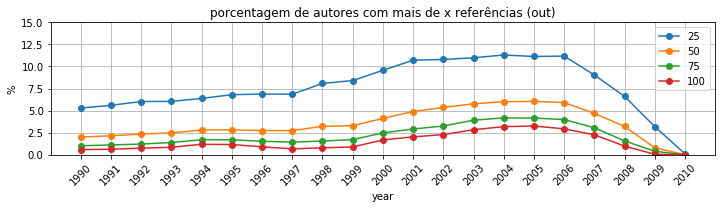

In [57]:
min_values = [25,50,75,100]
years,freqs_dict = get_min_freqs(authors_out,min_values)
plot_min_values(years,freqs_dict,'porcentagem de autores com mais de x referências (out)')

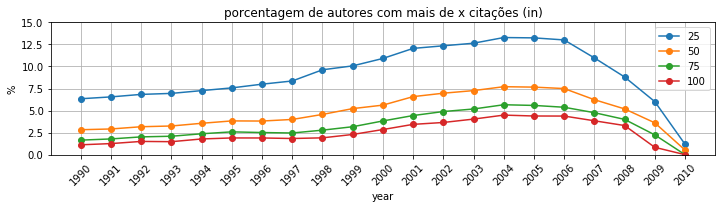

In [58]:
years,freqs_dict = get_min_freqs(authors_in,min_values)
plot_min_values(years,freqs_dict,'porcentagem de autores com mais de x citações (in)')

In [47]:
def get_total_of(data,get_out,filename):
    freqs = defaultdict(lambda:0)
    for paper in data.vs:
        authors_idxs = paper['authors_idxs'].split(',')
        value = get_out(paper,data)
        for author in authors_idxs:
            freqs[author] += value
    save(freqs,filename)
    return freqs

defaultdict(<function __main__.get_total_of.<locals>.<lambda>()>,
            {'1275668437': 2673,
             '246821553': 352,
             '2114421234': 136,
             '2138919347': 321,
             '739720355': 182,
             '1902042639': 236,
             '380877658': 482,
             '1370314892': 22,
             '2665776227': 5,
             '2050218935': 619,
             '2487817044': 186,
             '2675168138': 14,
             '2680511905': 14,
             '2710343950': 14,
             '2147481374': 282,
             '2100120781': 788,
             '2044280228': 597,
             '2103728845': 1988,
             '1963693510': 71,
             '1967297251': 32,
             '2115306259': 414,
             '2308716947': 94,
             '338026688': 223,
             '1472970498': 99,
             '2781950375': 3,
             '2119561202': 128,
             '368308055': 226,
             '2781535294': 3,
             '1999453495': 635,
             '219351860

In [48]:
get_total_of(data,get_out,'num_of_refs.json')
get_total_of(data,get_in,'num_of_citations.json')

defaultdict(<function __main__.get_total_of.<locals>.<lambda>()>,
            {'1275668437': 5552,
             '246821553': 4341,
             '2114421234': 4405,
             '2138919347': 2306,
             '739720355': 3935,
             '1902042639': 636,
             '380877658': 728,
             '1370314892': 198,
             '2665776227': 176,
             '2050218935': 2668,
             '2487817044': 1149,
             '2675168138': 428,
             '2680511905': 428,
             '2710343950': 428,
             '2147481374': 1146,
             '2100120781': 2317,
             '2044280228': 1467,
             '2103728845': 8362,
             '1963693510': 1400,
             '1967297251': 545,
             '2115306259': 2662,
             '2308716947': 332,
             '338026688': 806,
             '1472970498': 172,
             '2781950375': 314,
             '2119561202': 542,
             '368308055': 1736,
             '2781535294': 314,
             '1999453495': 25

In [45]:
def get_ranking_by_year(authors_in,years,N):
    ranking_by_year = dict()
    for year in years:
        ranking = []
        for a, a_hist in authors_in.items():
            if year in a_hist:
                count = a_hist[year]
                ranking.append((count,a))

        ranking = sorted(ranking,reverse=True)
        authors = []
        for c,a in ranking[:N]:
            authors.append(a)
    
        print(len(authors)*100/len(ranking))
        ranking_by_year[year] = authors
    return ranking_by_year

In [46]:
years = ['1990','1991','1992','1993','1994','1995','1996','1997','1998','1999','2000','2001','2002','2003','2004','2005','2006','2007','2008','2009']
ranking_by_year = get_ranking_by_year(authors_in,years,1000)

1.0487786972071023
0.9732928443510084
0.9193035356413981
0.8864069494304835
0.8585901948999742
0.8411348591519678
0.8232756491528493
0.8082571550964655
0.772934911151132
0.7659900421294523
0.7431960402514975
0.718902092723992
0.692084628108325
0.6856265255190193
0.6579813133307014
0.6386022274445693
0.6214461050865364
0.7115817038112316
0.8342301307238614
1.0662685930585916


In [48]:
save(ranking_by_year,'authors_in_ranking_by_year.json')

In [49]:
ranking_by_year = get_ranking_by_year(authors_out,years,1000)

1.0487786972071023
0.9732928443510084
0.9193035356413981
0.8864069494304835
0.8585901948999742
0.8411348591519678
0.8232756491528493
0.8082571550964655
0.772934911151132
0.7659900421294523
0.7431960402514975
0.718902092723992
0.692084628108325
0.6856265255190193
0.6579813133307014
0.6386022274445693
0.6214461050865364
0.7115817038112316
0.8342301307238614
1.0662685930585916


In [50]:
save(ranking_by_year,'authors_out_ranking_by_year.json')